In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [22]:
def load_mnist(start=None, end=None, ncols=None):
    with open('mnist.pkl', 'rb') as f:
        mnist = pickle.load(f)
    X, Y = mnist['X'], mnist['Y']
    mu, W = mnist['mu_whiten'], mnist['W_whiten']
    Y = Y[start:end] * 2 - 1
    X = (X[start:end] - mu) @ W[:, :ncols]
    return X, Y

X, Y = load_mnist(start=0, end=1000, ncols=100)
M = Y.shape[1]
N = X.shape[1]
P = X.shape[0]

In [23]:
C11 = X.T @ X / P
C31 = Y.T @ X / P
C33 = Y.T @ Y / P

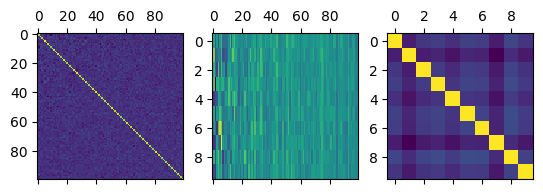

In [49]:
fig, axs = plt.subplots(1, 3)
axs[0].matshow(C11)
axs[1].matshow(C31, aspect=C31.shape[1] / C31.shape[0])
axs[2].matshow(C33);

Objective: model and understand gradient descent in linear neural network.

We assume the input X is whitened (reasonable in machine learning and biological systems with efficient coding upstream).

Our neural network has layers N1, N2, N3 parameterized by W21 and W32. We initialize the W's as random MxN matrices whose rows are M orthogonal, unit-length N-vectors. The rows of each W are a basis onto which each input vectors are projected to computed the output.

In [111]:
N1, N2, N3 = (100, 20, 10)
Q, R = np.linalg.qr(np.random.randn(N1, N1))
W21 = Q[:N2]
Q, R = np.linalg.qr(np.random.randn(N2, N2))
W32 = Q[:N3]

When it is evaluated, activations propagate forward through the network. The network accepts x as input. The first layer g1 takes on the values of x. The second layer computes g2(g1) where g2 is linear in g1. The third layer computes g3 = g3(g2) where g3 is linear in g2. The network outputs g3 as g(x).

When a layer or network computes, it does so on a batch of many x arranged as rows of a matrix X. A layer evaluating g_i parameterized by W_i then computes X @ W_i.T, where @ denotes matrix multiplication and .T means transpose. This yields a matrix Y with the y corresponding to each x along its rows. If W is MxN, then X has N columns and Y has M columns, and g projects N to M dimensions.

In [112]:
g1 = np.zeros((P, N))
g2 = np.zeros((P, 20))
g3 = np.zeros((P, M))
def g(X):
    g1 = X
    g2 = g1 @ W21.T
    g3 = g2 @ W32.T
    return g3

We evaluate the mapping on input X. Presently g(X) is a random orthonormal rotation of the input data.

In [113]:
gX = g(X)

Instead of randomly rotating the input data, we want g to transform inputs x to outputs g(x) that are as close to f(x) as can reasonably be expected from a linear network.

Claims:
1. If f is a linear mapping represented by W*, then SGD with MSE loss g can perfectly fit f by sending W32 W21 -> W*.
2. If f is a non-linear mapping, then the best that SGD with MSE loss can do is produce a g s.t. cov(X, g(X)) matches cov(X and f(X)).
    * In this case SGD sends the quantity cov(g(X), X) -> cov(Y, X).
    * By definition, cov(Y, X) = Y.T X / P.
    * Our network computes g(X) = X (W32 W21).T.
    * By definition, cov(g(X), X) = g(X).T X / P = W32 W21 X.T X / P.
    * X is whitened, so cov(X) = I = X.T @ X / P.
    * Then cov(g(X), X) = W32 W21, and SGD sends W32 W21 -> cov(Y, X).

With this in mind we implement the MSE loss. g outputs a PxM matrix matrix gX. These values are compared pointwise to the target matrix Y. The differences are squared and averaged over the whole matrix, resulting in a scalar value whose square root is the expected error per output unit for a random input example.

In [114]:
L = 0
E = np.zeros((P, M))
def loss(Y):
    E = Y - g3
    L = np.mean(E ** 2)
    return L

By design, g is a tunable mapping, with manipulation of W21 and W32 making accessible all linear functions.

g decomposes in two different senses: the function g is a composition of g's associated with layers and each layer is itself a composition of linear projections acting separately on the input. Our use of matrices to represent neurons and activations exploits the second fact and our use of the chain rule to propagate gradients exploits the first.

Observe that linear function $g$ parametrized by $W$ computes vector 

$$
\begin{bmatrix}
    g_1(\vec x) \\
    g_2(\vec x) \\
    \vdots \\
    g_M(\vec x)
\end{bmatrix} = 
\begin{bmatrix}
    \vec w_1^T \vec x \\
    \vec w_2^T \vec x \\
    \vdots \\
    \vec w_M^T \vec x
\end{bmatrix}
$$

where $\vec w_i$ means row $i$ of $W$. The dot product $\vec w_i^T \vec x$ is a sum $\sum_{j=1}^N w_{ij} x_j$ over the $N$ entries of $\vec w_i$ and $\vec x$. Therefore increasing the input element $x_j$, by $1$ increases the overall product by $w_{ij}$. Conversely, increasing matrix element $w_{ij}$ by $1$ increases the product by $x_j$. This means we can write:

$$
\frac{dg}{dW_{ij}} = x_j
$$
$$
\frac{dg}{dx_j} = 
\begin{bmatrix}
    w_{1j} \\
    w_{2j} \\
    \vdots \\
    w_{Mj}
\end{bmatrix}
$$

to propagate gradients backward through a layer from output $g(\vec x)$, to weights $W$, to input $\vec x$.

Note that the MSE loss is quadratic in the error $f(\vec x) - g(\vec x)$ and has derivative

$$\frac{dL}{dE_{ij}} = 2(f_j(\vec x_i) - g_j(\vec x_i))$$

with respect to error matrix $E$ where $\vec x_i$ denotes row $i$ of $X$, and $E$ is a $P\times M$ matrix whose column $j$ contains the errors made by output unit $j$ on each of the $P$ training examples. 

$E$ and $g$ are simply related by the derivative $$\frac{dE_{ij}}{dg_j} = -1$$.

Now we are equipped to write the chain rules for backpropagation through a single layer. This involves computing the derivative of loss with respect to the layer's weight matrix, and its derivative with respect to the layer's input.

In [115]:
dgdW = lambda X: X[:, np.newaxis, :] # (X rows, W output, W input)
dgdX = lambda W: W[np.newaxis, :, :] # (X rows, W output, X cols)
dLdW = lambda dLdg, X: np.mean(dLdg[:, :, np.newaxis] * dgdW(X), axis=0) # (W output, W input)
dLdX = lambda dLdg, W: np.sum(dLdg[:, :, np.newaxis] * dgdX(W), axis=1)  # (X rows, X cols)

To propagate gradients backward through the whole network, we chain deria

In [116]:
dLdW32 = np.zeros((M, 20))
dLdW21 = np.zeros((20, N))
def grad():
    dLdg3 = -2 / (P * M) * E
    dLdW32 = dLdW(dLdg3, g.g2)
    dLdg2 = dLdX(dLdg3, W32)
    dLdW21 = dLdW(dLdg2, g.g1)
    return dLdW21, dLdW32

Putting it all together, we define a network whose behavior is to
* compute forward pass when called with just X
* compute forward and backward pass when called with X and Y
* compute forward/backward passes and apply update when called with X, Y and learning rate

In [106]:
def network(X, Y=None, lr=None):
    g(X)
    if Y is None:
        return g3
    loss(X, Y)
    grad()
    if lr is not None:
        W21 -= lr * dLdW21
        W32 -= lr * dLdW32
    return L

In [117]:
g(X)

array([[ 1.92657836e+00, -8.18508523e-02, -1.35671977e+00, ...,
         1.14824282e-01,  4.98109640e-01,  8.28313072e-01],
       [ 1.35809823e+00,  6.42259822e-02, -3.59114732e-01, ...,
         1.47446269e+00,  4.54425534e-02, -8.63545831e-01],
       [-6.70071058e-01,  1.98789557e+00, -5.52660193e-01, ...,
         1.05515903e+00,  2.08229476e+00, -3.76790620e-01],
       ...,
       [ 7.23773834e-01,  6.39200445e-01,  2.88489125e-01, ...,
        -3.58686022e-01, -3.98083164e-04,  4.12177255e-01],
       [ 1.47217607e+00,  1.14355876e+00,  9.95387819e-01, ...,
        -4.80101963e-01,  2.13660145e+00, -1.29788759e+00],
       [ 3.64304980e-01,  4.63257259e-01, -1.24898818e+00, ...,
        -1.22090583e+00,  1.20371459e+00, -3.96373556e-02]])